In [ ]:
import torch

a = torch.randn(12).reshape(1, -1, 1).float()
avg = torch.nn.AvgPool1d(3,3)
a_avg = avg(a.permute(0,2,1)).permute(0,2,1)

mean = torch.mean(a, dim=1, keepdim=True)
stdev = torch.sqrt(torch.var(a, dim=1, keepdim=True, unbiased=False) + 1e-5)
a_norm = (a - mean) / stdev
a_norm_avg = avg(a_norm.permute(0,2,1)).permute(0,2,1)
torch.allclose(a_norm_avg*stdev + mean, a_avg)

In [ ]:
import torch
a = torch.arange(16).float()

a_fft_norm = torch.fft.rfft(a, norm='ortho')

k1 = 12
k2 = -2

print(a_fft_norm)
b = k1 * a + k2
print(b)
b_fft = a_fft_norm.clone() 
b_fft = b_fft * k1
b_fft[0] += k2 * len(a) ** 0.5 
print(b_fft)
# print(b_fft)
# print(b)
print(torch.fft.irfft(b_fft, norm='ortho'))
# torch.allclose(4*a, torch.fft.irfft(a_fft * 4))

In [ ]:
import torch
from src.utils.schedule import linear_schedule, cosine_schedule
import matplotlib.pyplot as plt

_,_,_,a = linear_schedule(1e-4, 1e-2, 288)
plt.plot(a)

In [ ]:
import torch

kernel_size = 100
# a = torch.sin(torch.linspace(0, torch.pi * 2, 1000)).float()
# a = a + torch.randn_like(a) * 0.1
a = torch.arange(100000).float()
a_std, a_mean = torch.std_mean(a)
print(a_std, a_mean)
a = torch.nn.functional.avg_pool1d(a.reshape(1, 1, -1), kernel_size, 1).flatten()
a_std, a_mean = torch.std_mean(a)
print(a_std, a_mean)

In [ ]:
import torch
import matplotlib.pyplot as plt

N = 1000
a = torch.sin(torch.linspace(0, 100, N)) + torch.exp(torch.linspace(0, 100, N) / 50)

plt.plot(a)
a_fft = torch.fft.rfft(a)
print(a_fft[0])
# plt.plot(a_fft.real)
# plt.plot(a_fft.imag)
noise = torch.randn(N)
a = a + noise
plt.plot(a)
a_fft = torch.fft.rfft(a)
print(a_fft[0])
print(torch.fft.rfft(noise)[0])
# plt.plot(a_fft.real)
# plt.plot(a_fft.imag)

In [ ]:
from torch.utils.data import DataLoader
from src.datamodule.data_loader import Dataset_Custom, Dataset_ETT_hour

dl = Dataset_ETT_hour(
    None,
    root_path="/home/user/data/THU-timeseries/ETT-small/",
    # root_path="/home/user/data/FrequencyDiffusion/dataset/",
    data_path="ETTh1.csv",
    # data_path="MFRED.csv",
    flag="test",
    size=[96, 48, 96],
    freq="h", scale=False
)
dl = DataLoader(dl, batch_size=128, shuffle=False, drop_last=True)
for batch in dl:
    seq_x, seq_y, seq_x_mark, seq_y_mark = batch
    print(seq_x.shape)
    print(seq_x[0, :10])
    print(seq_y[0, -96:])
    print(seq_x_mark[0,:10])
    break

In [ ]:
import torch

seq_len = 8
kernel_size = 3
a = torch.randn(seq_len).reshape(1, 1, seq_len)
avg = torch.nn.AvgPool1d(kernel_size=kernel_size, stride=1)
a_avg = avg(a)
print(a_avg)
a_interp = torch.nn.functional.interpolate(a_avg, size=seq_len, mode='nearest-exact')
a_interp

In [ ]:
conv = torch.zeros(seq_len, seq_len-kernel_size + 1)
start = 0
for i in range(conv.shape[1]):
    end = start + kernel_size
    conv[start:end, i] = 1/kernel_size
    start += 1
conv = conv.reshape(1, seq_len, seq_len-kernel_size + 1)
conv_interp = torch.nn.functional.interpolate(conv, size=seq_len, mode='nearest-exact').squeeze().T

# torch.einsum('tl,btc->blc', conv_interp.squeeze(), a.permute(0,2,1))
conv_interp @ a.permute(0,2,1)

In [ ]:
torch.eye(seq_len) - conv_interp @ conv_interp.T

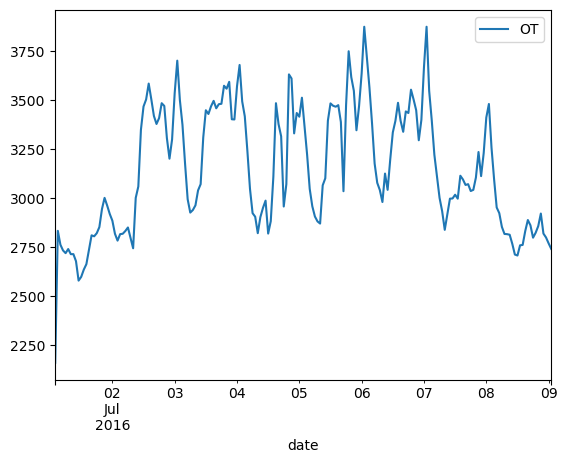

In [56]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from src.utils.filters import MovingAvgTime
seq_len = 192
df = pd.read_csv(
    # "/home/user/data/THU-timeseries/ETT-small/ETTh2.csv",
    "/home/user/data/THU-timeseries/electricity/electricity.csv",
    index_col=0,
    parse_dates=True,
)[["OT"]]
df = df[:seq_len]
df = df.astype(float)
df.plot()
x = torch.from_numpy(df.values.flatten()).float()

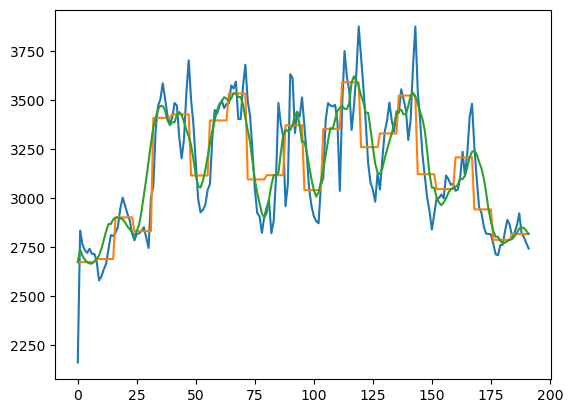

In [61]:
kernel_size = 8
stride = kernel_size
K = torch.zeros(seq_len, int((seq_len - kernel_size) / stride + 1))
start = 0
for i in range(K.shape[1]):
    end = start + kernel_size
    K[start:end, i] = 1 / kernel_size
    start += stride
K = K.unsqueeze(0)
# K = K.unsqueeze(1)
mode = "nearest-exact"
# mode = 'bilinear'
us = torch.nn.Upsample(seq_len, mode=mode)
K = us(K).squeeze().T
# K = torch.nn.functional.interpolate(K, size=seq_len, mode=mode).squeeze().T
# K
x_1 = K @ x.reshape(1, seq_len, 1)
plt.plot(df.values)
plt.plot(x_1.flatten())

stride=1
K = torch.zeros(seq_len, int((seq_len - kernel_size) / stride + 1))
start = 0
for i in range(K.shape[1]):
    end = start + kernel_size
    K[start:end, i] = 1 / kernel_size
    start += stride
K = K.unsqueeze(0)
# K = K.unsqueeze(1)
# mode = "nearest-exact"
mode = "nearest-exact" if stride == 1 else "linear"
us = torch.nn.Upsample(seq_len, mode=mode)
K = us(K).squeeze().T
# K = torch.nn.functional.interpolate(K, size=seq_len, mode=mode).squeeze().T
# K
x_1 = K @ x.reshape(1, seq_len, 1)


# x_1 = x_1.flatten().numpy().flatten()
# plt.plot(df.values)
plt.plot(x_1.flatten())

In [21]:
import pandas as pd

model_name = "MADtime_pl_FactOnly_FreqDoi"
    
batch_sizes = [64, 128, 256]
# batch_sizes = [32, 64, 128, 256]
all_df = []
for bs in batch_sizes:
    df = pd.read_csv(f'../assets/{model_name}_bs{bs}.csv')
    # df['slct_idx'] = df['MSE'] + df['CRPS']
    # df = df.drop(columns=['MSE','CRPS'])
    all_df.append(df)
all_df = pd.concat(all_df)
all_df = all_df.reset_index(drop=True)
# all_df
out_df = []
for g, dfg in all_df.groupby(['dataset', 'pred_len']):
    rk = dfg[["MSE",'CRPS']].rank().mean(axis=1)
    avg_rank = pd.concat([dfg[['method']], rk], axis=1)
    avg_rank = avg_rank.set_index('method')
    avg_rank = avg_rank.sort_values(by=0)
    best_model_name = avg_rank.index[0]
    out_df.append(dfg[dfg['method']  == best_model_name])
out_df = pd.concat(out_df)
out_df
    # mse_min_loc = (dfg['MSE'] == dfg['MSE'].min())
    # print(dfg[mse_min_loc]['method'].values[0])
    # crps_min_loc = (dfg['CRPS'] == dfg['CRPS'].min())
    # print(dfg[crps_min_loc]['method'].values[0])
    

,dataset,pred_len,MSE,CRPS,method
32,ECL,96,0.273215,0.156730,MADtime_pl_FactOnly_FreqDoi_bs128
1,ECL,192,0.295077,0.161452,MADtime_pl_FactOnly_FreqDoi_bs64
2,ECL,336,0.340636,0.176651,MADtime_pl_FactOnly_FreqDoi_bs64
3,ECL,720,0.415563,0.205925,MADtime_pl_FactOnly_FreqDoi_bs64
4,ETTh1,96,0.060445,0.079929,MADtime_pl_FactOnly_FreqDoi_bs64
69,ETTh1,192,0.079048,0.093084,MADtime_pl_FactOnly_FreqDoi_bs256
6,ETTh1,336,0.091763,0.102941,MADtime_pl_FactOnly_FreqDoi_bs64
7,ETTh1,720,0.125266,0.128988,MADtime_pl_FactOnly_FreqDoi_bs64
72,ETTh2,96,0.131605,0.120683,MADtime_pl_FactOnly_FreqDoi_bs256
73,ETTh2,192,0.184199,0.146096,MADtime_pl_FactOnly_FreqDoi_bs256
